## Eluvio data science challenge

In [12]:
from tqdm import tqdm
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

### ETL

In [13]:
%run 'scripts/dataloading.py'

In [14]:
# Load files
file_names, data = load_files(os.path.join("./", "eluvio_data/"))
print(file_names)

100%|██████████| 64/64 [00:01<00:00, 44.42it/s]

['tt0120890.pkl', 'tt2488496.pkl', 'tt1412386.pkl', 'tt0822832.pkl', 'tt0063442.pkl', 'tt0479884.pkl', 'tt0976051.pkl', 'tt0253474.pkl', 'tt1375666.pkl', 'tt0100405.pkl', 'tt0073195.pkl', 'tt0088247.pkl', 'tt0440963.pkl', 'tt0123755.pkl', 'tt2024544.pkl', 'tt0117060.pkl', 'tt1099212.pkl', 'tt0114746.pkl', 'tt0137523.pkl', 'tt0119488.pkl', 'tt0443272.pkl', 'tt0108399.pkl', 'tt0112573.pkl', 'tt1001508.pkl', 'tt0107290.pkl', 'tt1707386.pkl', 'tt0945513.pkl', 'tt1119646.pkl', 'tt0780571.pkl', 'tt0399201.pkl', 'tt0110604.pkl', 'tt0163025.pkl', 'tt0172495.pkl', 'tt0115759.pkl', 'tt0099423.pkl', 'tt0178868.pkl', 'tt0409459.pkl', 'tt0190332.pkl', 'tt2582846.pkl', 'tt0361748.pkl', 'tt0086190.pkl', 'tt0088944.pkl', 'tt1205489.pkl', 'tt0281358.pkl', 'tt0217505.pkl', 'tt0082089.pkl', 'tt0120689.pkl', 'tt0116282.pkl', 'tt0068646.pkl', 'tt0113277.pkl', 'tt0078788.pkl', 'tt0052357.pkl', 'tt0103776.pkl', 'tt0103855.pkl', 'tt0118715.pkl', 'tt0116922.pkl', 'tt0124315.pkl', 'tt0075314.pkl', 'tt0379786.pk

In [3]:
for k in [k for k in data[0].keys()][:-1]:
    print('-----------------------', k, '-----------------------')
    print(data[0][k].shape)

----------------------- place -----------------------
torch.Size([1151, 2048])
----------------------- cast -----------------------
torch.Size([1151, 512])
----------------------- action -----------------------
torch.Size([1151, 512])
----------------------- audio -----------------------
torch.Size([1151, 512])
----------------------- scene_transition_boundary_ground_truth -----------------------
torch.Size([1150])
----------------------- shot_end_frame -----------------------
torch.Size([1151])
----------------------- scene_transition_boundary_prediction -----------------------
torch.Size([1150])


### Dataset preparation

In [16]:
%run 'scripts/datautils.py'

In [17]:
holdout_set_num = 1

# bound_pred_dataset = loadBoundPredDataset(data[0])
# boundary_gt_dataset = loadBoundGroundTruthDataset(data[0])
movie_dataset = loadDatasets(data[:-holdout_set_num], loadBoundPredDatasetA)
movie_dataset

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.8525, 0.0000, 0.0000],
        ...,
        [0.1160, 1.8896, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6467, 1.1901, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0040, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

In [18]:
dataset = movie_dataset
train_set, test_set = getTrainTestSet(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])

In [19]:
print(len(train_set.indices))
print(len(test_set.indices))

83312
20828


### Model

In [8]:
# Feature Extraction models
# BNet
class BNet(torch.nn.Module):
    def __init__(self, shot_num=1, channel=512):
        super(BNet, self).__init__()
        self.shot_num = shot_num
        self.channel = channel
        self.conv1 = torch.nn.Conv2d(1, self.channel, kernel_size=(self.shot_num, 1))
        self.max3d = torch.nn.MaxPool3d(kernel_size=(self.channel, 1, 1))
        self.conv2 = torch.nn.Conv2d(1, self.channel, kernel_size=(self.shot_num, 1))

    def forward(self, x):  # [batch_size, seq_len, shot_num, feat_dim]
        context = x.view(x.shape[0], -1, 1, x.shape[-1])
        context = self.conv1(context)  # batch_size*seq_len,512,1,feat_dim
        context = self.max3d(context)  # batch_size*seq_len,1,1,feat_dim
        context = context.squeeze()
        cview = x.view(x.shape[0], -1, 1, x.shape[-1])
        cview = cview.view(-1, 1, cview.shape[2], cview.shape[3])
        part1, part2 = torch.split(cview, [x.shape[-1]//2, x.shape[-1]//2], dim=3)
        # batch_size*seq_len, 1, [self.shot_num//2], feat_dim
        part1 = self.conv2(part1).squeeze()
        part2 = self.conv2(part2).squeeze()
        sim = torch.nn.functional.cosine_similarity(part1, part2, dim=2)
        bound = torch.cat((context, sim), dim=1)
        return bound

In [9]:
# Binary scene classification models
class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        outputs = self.linear(x)
        return outputs

class biLSTM(torch.nn.Module):
    def __init__(self, input_dim, output_dim=2, num_layers=1, lstm_hidden_size=512, seq_len=8):
        super(biLSTM, self).__init__()
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lstm_hidden_size = lstm_hidden_size
        self.seq_len = seq_len
        self.bnet = BNet()
        self.lstm = torch.nn.LSTM(input_size=self.input_dim,
                                  hidden_size=self.lstm_hidden_size,
                                  num_layers=1,
                                  batch_first=True,
                                  bidirectional=False)
        self.fc1 = torch.nn.Linear(self.lstm_hidden_size, 100)
        self.fc2 = torch.nn.Linear(100, output_dim)

    def forward(self, x):
        x_in = self.bnet(x)
        x_view_in = x_in.view(-1, self.seq_len, x_in.shape[-1])
        self.lstm.flatten_parameters()
        out, _ = self.lstm(x_view_in, None)
        out = torch.nn.functional.relu(self.fc1(out))
        out = self.fc2(out)
        out = out.view(-1, 2)
#         out = torch.nn.functional.softmax(out, dim=0)
        
        return out

### Training

In [10]:
params = {'batch_size': 128,
          'n_iters': 1500,
          'input_dim': 514,
          'output_dim': 2,
          'lr_rate': 0.001}

epochs = int(params['n_iters'] / (len(train_set) / params['batch_size']))

print(f'params:\n{params}\nepochs: {epochs}\n')
loss_dict = {'train': [], 'test': [], 'accuracy': []}

model = biLSTM(params['input_dim']+512, params['output_dim'])
# model2 = LinearRegression(params['output_dim'], params['output_dim'])
criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.5, 5]))
optimizer = torch.optim.SGD(model.parameters(), lr=params['lr_rate'])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=params['batch_size'], drop_last=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=params['batch_size'], drop_last=True)

iter = 0
for epoch in range(int(epochs)):
    for i, x in enumerate(trainloader):
        x_in = torch.autograd.Variable(x[:,:-1])
        y_in = torch.autograd.Variable(x[:,-1]).type(torch.LongTensor)
        
        optimizer.zero_grad()
        y_pred = model(x_in)
        loss = criterion(y_pred, y_in)
        loss.backward()
        optimizer.step()

        iter = iter+1
        if iter%100 == 0:
            total_loss = 0
            total = 0
            correct = 0
            for x in testloader:
                x_in = x[:,:-1]
                y_in = torch.Tensor(x[:,-1]).type(torch.LongTensor)
                with torch.no_grad():
                    y_pred = model(x_in)
                    test_loss = criterion(y_pred, y_in)
                    total_loss = total_loss + test_loss.item()
                    
                    # For binary classification
                    for y in range(len(y_pred)):
                        total = total + 1
#                         y_out = torch.nn.functional.softmax(y_pred[y], dim=0)
                        y_out = y_pred[y]
#                         print(torch.argmax(y_out).item(), y_in[y].item())
                        if torch.argmax(y_out).item() == y_in[y].item():
                            correct = correct + 1

            loss_dict['train'].append(loss.item())
            loss_dict['test'].append(total_loss)
            loss_dict['accuracy'].append(correct/total)
            print("Iteration: {}. TrainLoss: {}. TestLoss: {}.".format(iter, loss.item(), total_loss))
            print("Accuracy: {}".format(correct/total))

params:
{'batch_size': 128, 'n_iters': 1500, 'input_dim': 514, 'output_dim': 2, 'lr_rate': 0.001}
epochs: 2



/home/kslotay/.conda/envs/py36/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370193460/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Iteration: 100. TrainLoss: 0.7036486864089966. TestLoss: 111.09425437450409.
Accuracy: 0.923804012345679
Iteration: 200. TrainLoss: 0.692289412021637. TestLoss: 110.75550651550293.
Accuracy: 0.9241415895061729
Iteration: 300. TrainLoss: 0.6742932200431824. TestLoss: 110.59499388933182.
Accuracy: 0.9241415895061729
Iteration: 400. TrainLoss: 0.6903908252716064. TestLoss: 110.46623849868774.
Accuracy: 0.9235628858024691
Iteration: 500. TrainLoss: 0.702307403087616. TestLoss: 110.35186451673508.
Accuracy: 0.9216338734567902
Iteration: 600. TrainLoss: 0.6732595562934875. TestLoss: 110.24372565746307.
Accuracy: 0.9136766975308642
Iteration: 700. TrainLoss: 0.7158713936805725. TestLoss: 110.15717166662216.
Accuracy: 0.8659336419753086
Iteration: 800. TrainLoss: 0.6795190572738647. TestLoss: 110.0971417427063.
Accuracy: 0.8088831018518519
Iteration: 900. TrainLoss: 0.6862257719039917. TestLoss: 110.0310645699501.
Accuracy: 0.8375771604938271
Iteration: 1000. TrainLoss: 0.6670252084732056. Tes

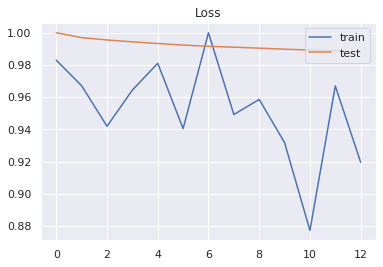

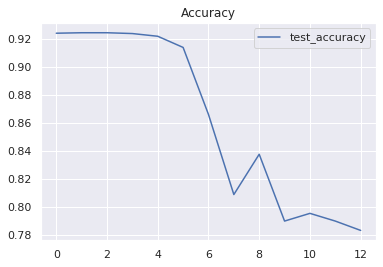

In [11]:
plt.figure()
plt.title('Loss')
plt.plot(np.array(loss_dict['train'])/max(loss_dict['train']), label='train')
plt.plot(np.array(loss_dict['test'])/max(loss_dict['test']), label='test')
plt.legend(loc='upper right')

plt.figure()
plt.title('Accuracy')
plt.plot(loss_dict['accuracy'], label='test_accuracy')
plt.legend(loc='upper right')

### Scenecut Optimization

In [ ]:
%run 'scripts/scenecutoptim.py'

In [421]:
# Implement DP/iterative optimization for scene segmentation given supershot representations

memo, scenecutscores = optimizeSceneCutSet(bound_pred_dataset[:,:-1], data[0]['scene_transition_boundary_prediction'])

### Evaluation

In [20]:
%run 'scripts/eluvioevalfuncs.py'

In [13]:
from sklearn.metrics import classification_report
# Shot Boundary Prediction Model evaluation

criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.5, 5]))
model.eval()
eval_dict = {'test': [], 'accuracy': [], 'preds': []}
y_preds_list = []
y_gt_list = []
with torch.no_grad():
    eval_total = 0
    eval_correct = 0
    for idx, x in enumerate(testloader):
        x_in = x[:,:-1]
        y_in = torch.Tensor(x[:,-1]).type(torch.LongTensor)
        with torch.no_grad():
            y_pred = model(x_in)
            test_loss = criterion(y_pred, y_in)
            total_loss = total_loss + test_loss.item()
            # For binary classification
            for y in range(len(y_pred)):
                eval_total = eval_total + 1
                y_out = torch.nn.functional.softmax(y_pred[y], dim=0)
                if torch.argmax(y_out).item() == y_in[y].item():
                    eval_correct = eval_correct + 1
                    
                y_preds_list.append(torch.argmax(y_out).item())
                y_gt_list.append(y_in[y].item())

            eval_dict['test'].append(total_loss)
            eval_dict['accuracy'].append(eval_correct/eval_total)
    print("Accuracy: {} TestLoss: {}.".format(eval_correct/eval_total, total_loss))

print(classification_report(y_gt_list, y_preds_list))

Accuracy: 0.7833236882716049 TestLoss: 219.55426132678986.
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     19163
           1       0.11      0.26      0.16      1573

    accuracy                           0.78     20736
   macro avg       0.52      0.55      0.52     20736
weighted avg       0.87      0.78      0.82     20736



In [14]:
import json

def get_argmax(row):
    return np.argmax(row)

def get_eval_loader(data):
    eval_loader = torch.utils.data.DataLoader(data, batch_size=params['batch_size'], drop_last=True)
    
    return eval_loader
    
def tensor_from_loader(dataloader):
    cat_data = torch.Tensor([])
    for d in dataloader:
        cat_data = torch.cat((cat_data, d), dim=0)
        
    return cat_data

gt_dict = dict()
pr_dict = dict()
shot_to_end_frame_dict = dict()

gt_dict_loader = get_eval_loader(loadDatasetsCol([data[-1]], "scene_transition_boundary_ground_truth", 'unsqueeze'))
gt_dict['test'] = tensor_from_loader(gt_dict_loader)

x_in_loader = get_eval_loader(loadDatasets([data[-1]], loadBoundPredDatasetA))
x_in = tensor_from_loader(x_in_loader)
with torch.no_grad():
#     x_in = loadDatasetsCol([data[-1]], "scene_transition_boundary_prediction", 'unsqueeze')
    x_in = x_in[:,:-1]
    pr_dict['test'] = torch.nn.functional.softmax(model(x_in), dim=1)
    pr_dict['test'] = np.array([np.argmax(p) for p in pr_dict['test'].numpy()])
    
shot_to_end_frame_dict['test'] = loadDatasetsCol([data[-1]], 'shot_end_frame', 'none').view(-1)

scores = dict()
scores["AP"], scores["mAP"], _ = calc_ap(gt_dict, pr_dict)
scores["Miou"], _ = calc_miou(gt_dict, pr_dict, shot_to_end_frame_dict)
scores["Precision"], scores["Recall"], scores["F1"], *_ = calc_precision_recall(gt_dict, pr_dict)

print("Scores:", json.dumps(scores, indent=4))

Scores: {
    "AP": 0.09636659370611425,
    "mAP": 0.09636659370611425,
    "Miou": 0.33720653028401065,
    "Precision": 149.0,
    "Recall": 241.0,
    "F1": 184.14871794871794
}
